Source: https://github.com/wxs/keras-mnist-tutorial

In [1]:
%matplotlib inline

# Building a simple neural-network with Keras

**Author: Xavier Snelgrove**

This is a simple quick-start in performing digit recognition in a neural network in Keras, for a short tutorial at the University of Toronto. It is largely based on the `mnist_mlp.py` example from the Keras source.


## Time to build a neural network!
First let's import some prerequisites

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

import keras
print keras.__version__

2.2.3


## Load training data

In [3]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

('X_train original shape', (60000, 28, 28))
('y_train original shape', (60000,))


Let's look at some examples of the training data

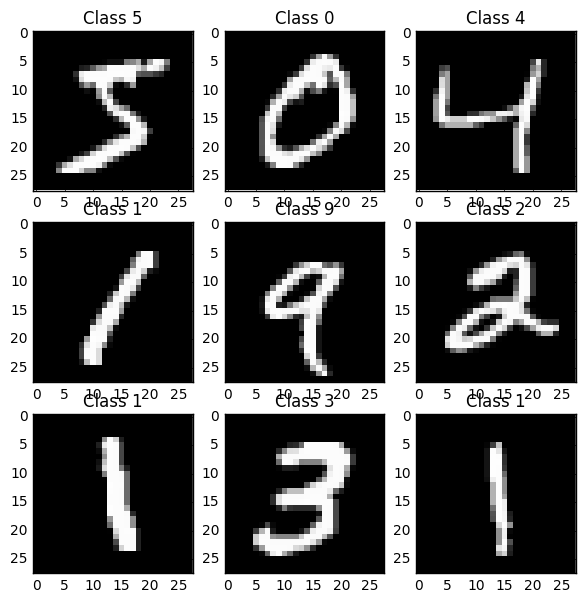

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## Format the data for training
Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. We'll also scale the inputs to be in the range [0-1] rather than [0-255]

In [5]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

('Training matrix shape', (60000, 784))
('Testing matrix shape', (10000, 784))


Modify the target matrices to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

In [8]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
Y_train[:3]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

# Build the neural network
Build the neural-network. Here we'll do a simple 3 layer fully connected network.
<img src="https://github.com/wxs/keras-mnist-tutorial/raw/8824b7b56963a92ef879f09acd99cf3a210db2b8/figure.png" />

In [49]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.2))       # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
#model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.
import tensorflow as tf
model.add(Activation(tf.nn.softmax))

In [40]:
# import tensorflow as tf
# model = Sequential()
# model.add(Dense(10, input_shape=(784,)))
# model.add(Activation(tf.nn.softmax))

## Compile the model
Keras is built on top of Theano (and now TensorFlow as well), both packages that allow you to define a *computation graph* in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical crossentropy*, and is a loss function well-suited to comparing two probability distributions.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". We won't discuss this in too much detail, but "adam" is often a good choice (developed here at U of T).

In [50]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Train the model!
This is the fun part: you can feed the training data loaded in earlier into this model and it will learn to classify digits

In [51]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=4, ##show_accuracy=True,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 95us/step - loss: 0.2516 - val_loss: 0.1034
Epoch 2/4
60000/60000 [==============================] - 5s 89us/step - loss: 0.1018 - val_loss: 0.0743
Epoch 3/4
60000/60000 [==============================] - 6s 93us/step - loss: 0.0711 - val_loss: 0.0639
Epoch 4/4
60000/60000 [==============================] - 6s 95us/step - loss: 0.0560 - val_loss: 0.0629


## Finally, evaluate its performance

In [43]:
score = model.evaluate(X_test, Y_test, ##show_accuracy=True,
                       verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])
print score

0.2848800954639912


In [28]:
model.metrics_names

['loss']

### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [52]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

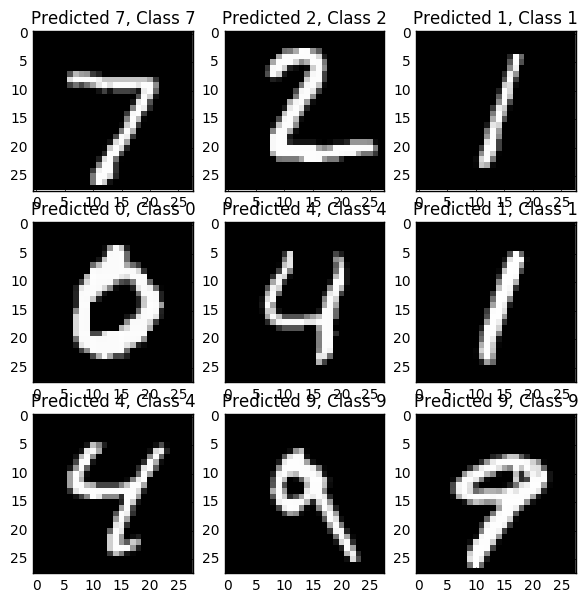

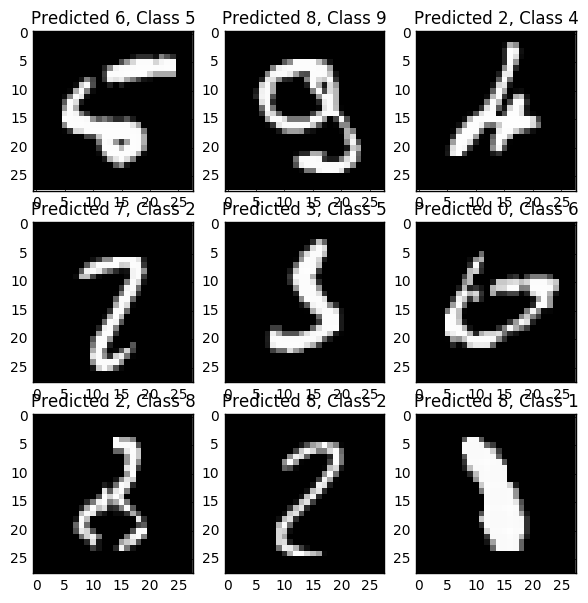

In [53]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

In [38]:
def print_confusion_matrix(cls_pred, cls_true, num_classes):
    from sklearn.metrics import confusion_matrix
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

[[ 970    0    0    1    1    0    4    1    3    0]
 [   0 1122    3    0    0    1    3    4    2    0]
 [   3    0 1003    4    3    0    4    8    7    0]
 [   0    0    1  992    0    7    0    4    3    3]
 [   0    0    2    0  965    0    4    3    1    7]
 [   2    0    0    5    1  869    8    0    6    1]
 [   1    2    0    1    3    2  948    0    1    0]
 [   1    2    7    0    0    0    0 1011    2    5]
 [   3    0    3    5    2    3    0    4  949    5]
 [   4    2    0    5    8    4    0    8    3  975]]


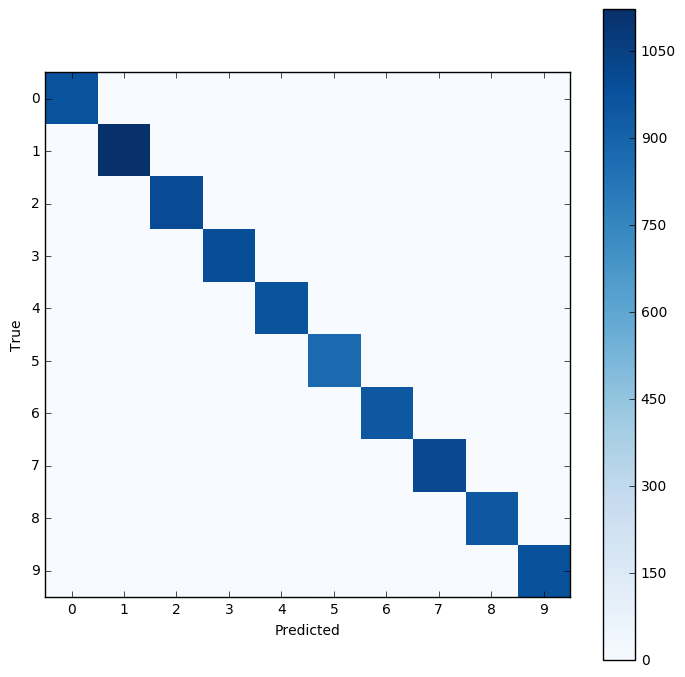

In [54]:
print_confusion_matrix(predicted_classes, y_test, nb_classes)

In [55]:
from sklearn.metrics import classification_report
print classification_report(y_test, predicted_classes, target_names=["'%d'"%i for i in range(10)])


             precision    recall  f1-score   support

        '0'       0.99      0.99      0.99       980
        '1'       0.99      0.99      0.99      1135
        '2'       0.98      0.97      0.98      1032
        '3'       0.98      0.98      0.98      1010
        '4'       0.98      0.98      0.98       982
        '5'       0.98      0.97      0.98       892
        '6'       0.98      0.99      0.98       958
        '7'       0.97      0.98      0.98      1028
        '8'       0.97      0.97      0.97       974
        '9'       0.98      0.97      0.97      1009

avg / total       0.98      0.98      0.98     10000



# That's all!

There are lots of other great examples at the Keras homepage at http://keras.io and in the source code at https://github.com/fchollet/keras